In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# CXR Modality-specific pretraining

## Import all the packages

In [ ]:
import cv2
import os
import datetime
import time
import numpy as np

ModuleNotFoundError: No module named 'cv2'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

## Load the dataset

| Source|TB | NTB | NORM|
|-------|---|-----|------|
|NIH|4287|-|-|
|TBX11K|800|3800|3800|
|pediatric-pnemonia|-|4273|1575|
|**Total Training**|**5087**|**8073**|**5314**|
|Shenzhen|336|-|326|
|Montegomery|58|-|80|
|**Total**|||5394|


In [5]:
import glob
filename = glob.glob(r'./dataset/TBNTBN/train/TB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/train/NTB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/train/NORM/*.*')
print(len(filename))



5087
8065
5375


In [6]:
import glob
filename = glob.glob(r'./dataset/TBNTBN/test/TB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/test/NTB/*.*')
print(len(filename))
filename = glob.glob(r'./dataset/TBNTBN/test/NORM/*.*')
print(len(filename))




58
390
245


In [7]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_dir = './dataset/TBNTBN/train/'
test_dir = './dataset/TBNTBN/test/'

In [8]:
from scripts.create_dataset import create_dataset


In [9]:
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()


In [10]:
train_data, train_y =create_dataset(train_dir,IMG_SIZE)
target_val = train.fit_transform(train_y)


loading 500th image for class TB
loading 1000th image for class TB
loading 1500th image for class TB
loading 2000th image for class TB
loading 2500th image for class TB
loading 3000th image for class TB
loading 3500th image for class TB
loading 4000th image for class TB
loading 4500th image for class TB
loading 5000th image for class TB
loading 500th image for class NTB
loading 1000th image for class NTB
loading 1500th image for class NTB
loading 2000th image for class NTB
loading 2500th image for class NTB
loading 3000th image for class NTB
loading 3500th image for class NTB
loading 4000th image for class NTB
loading 4500th image for class NTB
loading 5000th image for class NTB
loading 5500th image for class NTB
loading 6000th image for class NTB
loading 6500th image for class NTB
loading 7000th image for class NTB
loading 7500th image for class NTB
loading 8000th image for class NTB
loading 500th image for class NORM
loading 1000th image for class NORM
loading 1500th image for class 

In [11]:
# test = LabelBinarizer()
# X_test,y_test = create_dataset(test_dir)
# y_test = test.fit_transform(y_test)
# X_test = np.array(X_test,)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data, ), 
                                                    target_val, 
                                                    test_size=0.15,
                                                    random_state=42)



In [13]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)


In [14]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Metal device set to: Apple M1


2022-09-05 13:39:56.779444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 13:39:56.781405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
# tf.keras.utils.plot_model(model, "without_sincnet.png", show_shapes=True)

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-8 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='output/class_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,save_weights_only=True,verbose=1)
           ]

2022-09-05 11:54:42.175228: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-05 11:54:42.175237: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-05 11:54:42.175624: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [16]:
history = model.fit(x=X_train, 
                    y = y_train,
                    validation_split=0.15,
                    epochs=15,
                    batch_size = 16,
                   callbacks=callback)


2022-09-05 11:54:42.405446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-05 11:54:42.412085: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15


2022-09-05 11:54:43.330573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  2/837 [..............................] - ETA: 2:50 - loss: 1.2728 - accuracy: 0.3125 

2022-09-05 11:54:44.135450: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-05 11:54:44.135461: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-05 11:54:44.293013: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-05 11:54:44.297074: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-05 11:54:44.301747: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220905-115442/train/plugins/profile/2022_09_05_11_54_44
2022-09-05 11:54:44.304230: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220905-115442/train/plugins/profile/2022_09_05_11_54_44/users-MacBook-Pro.local.trace.json.gz
2022-09-05 11:54:44.307409: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220905-115442/tr

837/837 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9331

2022-09-05 11:57:00.130038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


837/837 [==============================] - 144s 171ms/step - loss: 0.1941 - accuracy: 0.9331 - val_loss: 0.3743 - val_accuracy: 0.8477

Epoch 00001: val_loss improved from inf to 0.37426, saving model to output/class_weights.01-0.37.hdf5
Epoch 2/15
837/837 [==============================] - 144s 172ms/step - loss: 0.0779 - accuracy: 0.9733 - val_loss: 0.0641 - val_accuracy: 0.9797

Epoch 00002: val_loss improved from 0.37426 to 0.06410, saving model to output/class_weights.02-0.06.hdf5
Epoch 3/15
837/837 [==============================] - 148s 177ms/step - loss: 0.0517 - accuracy: 0.9822 - val_loss: 0.0664 - val_accuracy: 0.9797

Epoch 00003: val_loss did not improve from 0.06410
Epoch 4/15
837/837 [==============================] - 145s 174ms/step - loss: 0.0341 - accuracy: 0.9883 - val_loss: 0.0868 - val_accuracy: 0.9704

Epoch 00004: val_loss did not improve from 0.06410
Epoch 5/15
837/837 [==============================] - 147s 176ms/step - loss: 0.0293 - accuracy: 0.9897 - val_los

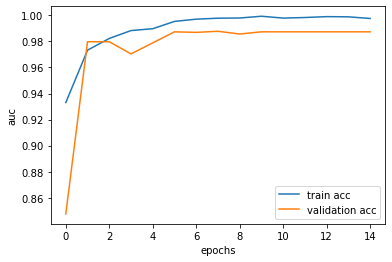

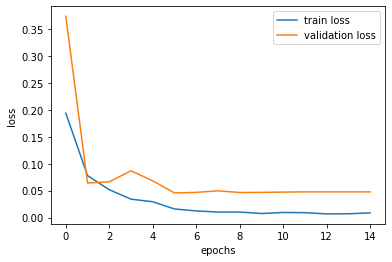

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train acc','validation acc'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


In [15]:
model = build_model(input_shape=(256,256,3))
model.load_weights('output/class_weights.07-0.04.hdf5')
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])


In [16]:
model.evaluate(X_test,y_test)



2022-09-05 13:39:58.159134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-05 13:39:58.162179: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-05 13:39:58.433824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 7s 79ms/step - loss: 0.0681 - accuracy: 0.9892


[0.06811036169528961, 0.9892086386680603]

In [17]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(138,3)


2022-09-05 13:40:05.691021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
pred = np.zeros((y_test.shape[0]))
for i,p in enumerate(predictions):
    l = np.argmax(p)
    pred[i] = l
    

In [22]:
# predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [np.argmax(yy) for yy in y_test]


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y,pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       772
           1       0.99      0.99      0.99      1258
           2       0.99      0.99      0.99       750

    accuracy                           0.99      2780
   macro avg       0.99      0.99      0.99      2780
weighted avg       0.99      0.99      0.99      2780



In [24]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':pred})
print(df['ytrue'].value_counts())
print(df['pred'].value_counts())


1    1258
0     772
2     750
Name: ytrue, dtype: int64
1.0    1256
0.0     774
2.0     750
Name: pred, dtype: int64


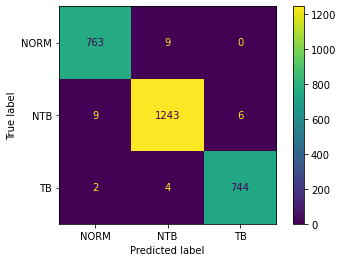

In [25]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y,pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORM','NTB','TB'])
disp.plot()

plt.savefig('confusionmatrix.png')
plt.show()


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y,pred,labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       772
           1       0.99      0.99      0.99      1258
           2       0.99      0.99      0.99       750

    accuracy                           0.99      2780
   macro avg       0.99      0.99      0.99      2780
weighted avg       0.99      0.99      0.99      2780



In [20]:
from scripts.create_dataset import get_img_array
from scripts.display_heatmap import save_and_display_gradcam
from scripts.model_explanation import make_cam_heatmap, make_gradcam_heatmap, make_grad_cam_pp_heatmap

In [21]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

1 [3.8367540e-07 1.2938888e-05 9.9998665e-01]
2 [1.0241524e-07 9.9989855e-01 1.0138356e-04]
3 [3.5499076e-07 5.4235638e-06 9.9999428e-01]
4 [5.2409723e-07 9.9999917e-01 2.8985949e-07]
5 [1.6708217e-06 9.9997675e-01 2.1582564e-05]
6 [1.4928338e-04 9.9985063e-01 3.3162301e-08]
7 [2.8014448e-04 9.9941790e-01 3.0199619e-04]
8 [9.9999869e-01 8.4848477e-07 4.3742983e-07]
9 [3.0371865e-07 9.9999452e-01 5.2189189e-06]
10 [1.0577143e-05 3.8330071e-04 9.9960607e-01]


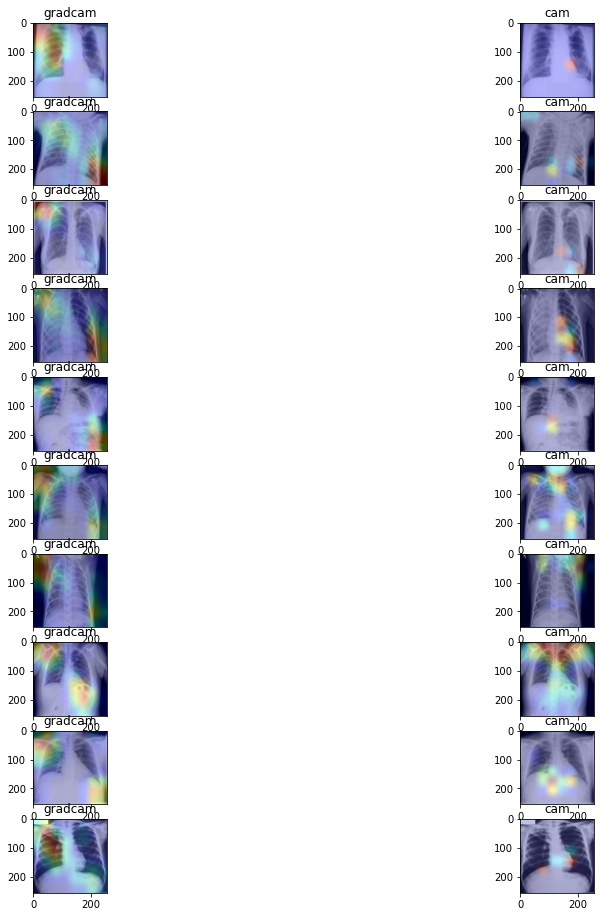

In [22]:
plt.figure(figsize=(16, 16))

for count in range(1,11):#(len(filename)):
#     im = cv2.imread(filename[count])
#     im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
#     img = tf.keras.preprocessing.image.load_img(
#         filename[count],
#         color_mode='rgb', 
#         target_size=(256, 256))
#     img = tf.keras.preprocessing.image.img_to_array(img)
    img = X_test[count+10]
    im = img
    img = np.reshape(img,(1,256,256,3))
    print(count,max(model.predict(img)))
   
    heatmap_cam = make_cam_heatmap(img, model, 'out_relu')
    heatmap_gradcam = make_grad_cam_pp_heatmap(img, model, 'out_relu')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    

2022-09-05 13:50:00.834977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


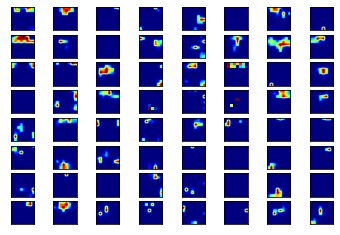

In [23]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'out_relu'

mdl = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = load_img(filename[1], target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

# Apply the model to the image
feature_maps = mdl.predict(image)

square = 8
index = 1
for _ in range(square):
    for _ in range(square):
        
        ax = plt.subplot(square, square, index)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(feature_maps[0, :, :, index-1], cmap='jet')
        index += 1
        
plt.show()